*Notebook source: https://www.kaggle.com/code/serkanpeldek/face-recognition-on-olivetti-dataset*

Note -- This might be better (later change)  
https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

<hr>

### Load dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 2914
n_classes: 7


In [3]:
for i, j in zip(*np.unique(y, return_counts=True)):
    print(f'Subject #{i} has {j} images')

Subject #0 has 77 images
Subject #1 has 236 images
Subject #2 has 121 images
Subject #3 has 530 images
Subject #4 has 109 images
Subject #5 has 71 images
Subject #6 has 144 images


### Show image

In [4]:
def show_10_faces_of_subject(images, labels):

    cols = 10
    rows = 7
    
    fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(2*rows,int(1.5*cols)), facecolor='white')
    
    for i in range(rows):
        subject_indices = np.where(y==i)[0]
        for j in range(cols):
            axarr[i,j].imshow(images[subject_indices[j]], cmap='gray')
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title('face id:{}'.format(i))

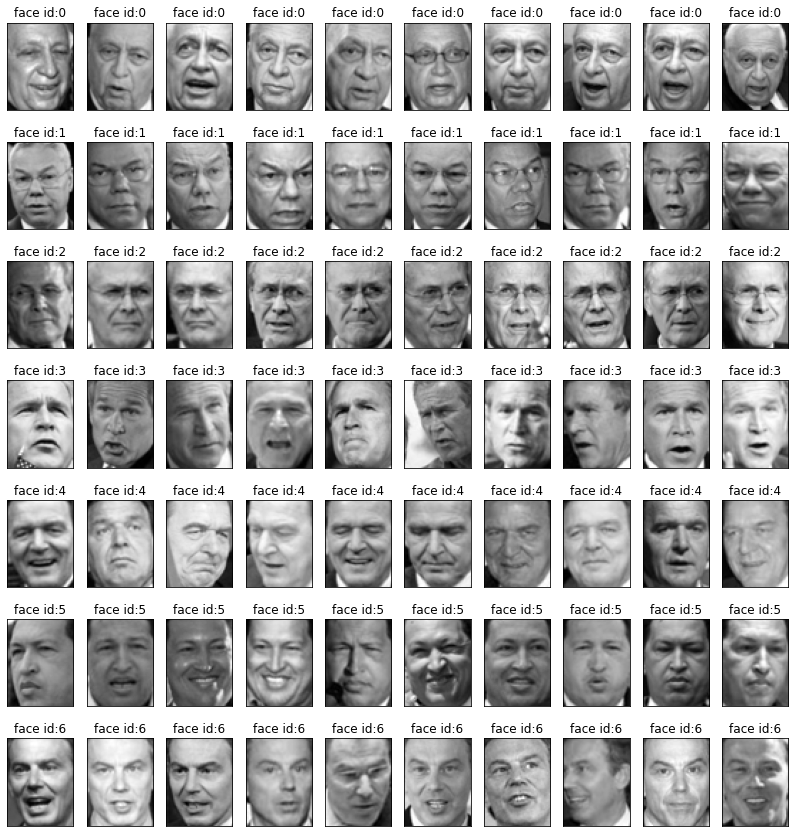

In [5]:
show_10_faces_of_subject(images=lfw_people.images, labels=y)

### Prepare dataset for PCA

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (901, 2914)
y_train shape: (901,)
X_test shape: (387, 2914)
y_test shape: (387,)


In [7]:
df_counts = pd.DataFrame({
    'subject_id': np.arange(n_classes),
    'train': np.unique(y_train, return_counts=True)[1],
    'test': np.unique(y_test, return_counts=True)[1],
    'total': np.unique(y, return_counts=True)[1]
})

print('Image counts')
df_counts.set_index('subject_id')

Image counts


,train,test,total
subject_id,,,
0,54,23,77
1,165,71,236
2,84,37,121
3,371,159,530
4,76,33,109
5,50,21,71
6,101,43,144


### PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.utils.extmath import svd_flip

In [9]:
n_components = 200

# PCA from sklearn
sk_pca = PCA(n_components=n_components, svd_solver='full')
sk_F_train = sk_pca.fit_transform(X_train)

In [10]:
X_train_mean = np.mean(X_train, axis=0)
X_train_centered = X_train - X_train_mean

X_train_centered.shape

(901, 2914)

In [11]:
U, S, Vt = np.linalg.svd(X_train_centered, full_matrices=False)
U, Vt = svd_flip(U, Vt)

U.shape, S.shape, Vt.shape

((901, 901), (901,), (901, 2914))

In [12]:
# Check that SVD reconstruction is correct
assert np.allclose(X_train_centered, U @ np.diag(S) @ Vt, atol=1e-3)

# Check that the first n_components of Vt are the same as the first n_components of sk_pca.components_
assert np.allclose(X_train_centered @ Vt[:n_components].T, sk_F_train, atol=1e-3)

print('All test cases passed!')

All test cases passed!


In [13]:
from scipy.spatial.distance import mahalanobis, euclidean
from sklearn.metrics import accuracy_score

In [14]:
class PCA_Self:

    def __init__(self, weights_path=None):

        if weights_path is not None:
            self.load_weights(weights_path)

    def fit(self, X):

        self.n_samples, self.n_features = X.shape
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
        U, Vt = svd_flip(U, Vt)  # Flip the sign of the columns of U and V to enforce deterministic output
        
        self.Vt = Vt
        self.S = S

    def transform(self, X, n_components):

        if n_components is None:
            n_components = self.n_features

        return (X - self.mean) @ self.Vt[:n_components].T
    
    def load_weights(self, weights_path):

        with np.load(weights_path) as data:
            self.mean = data['mean']
            self.Vt = data['Vt']
            self.variance = data['var']

    def save_weights(self, weights_path):

        np.savez(weights_path, mean=self.mean, Vt=self.Vt, var=self.var)

    def get_inv_cov_matrix(self, n_components):

        return np.diag(1 / self.S[:n_components]**2)


n_components = 80

pca_self = PCA_Self()
pca_self.fit(X_train)
F_train = pca_self.transform(X_train, n_components=n_components)
F_test = pca_self.transform(X_test, n_components=n_components)

# Check that the first n_components of Vt are the same as the first n_components of sk_pca.components_
# assert np.allclose(sk_F_train, F_train, atol=1e-3)


inv_cov_matrix = pca_self.get_inv_cov_matrix(n_components=n_components)

mu_fj = []

for i in range(n_classes):
    subject_indices = np.where(y_train==i)[0]
    mu_fj.append(np.mean(F_train[subject_indices], axis=0))


y_train_preds, y_test_preds = [], []

for i in range(len(F_train)):

    dist = np.array([mahalanobis(F_train[i], mu_fj[j], inv_cov_matrix) for j in range(n_classes)])
    # dist = np.array([euclidean(F_train[i], mu_fj[j]) for j in range(n_classes)])
    y_train_preds.append(np.argmin(dist))

for i in range(len(F_test)):

    dist = np.array([mahalanobis(F_test[i], mu_fj[j], inv_cov_matrix) for j in range(n_classes)])
    # dist = np.array([euclidean(F_test[i], mu_fj[j]) for j in range(n_classes)])
    y_test_preds.append(np.argmin(dist))

accuracy_score(y_train_preds, y_train), accuracy_score(y_test_preds, y_test)

(0.8623751387347391, 0.8062015503875969)

In [15]:
# n_j, indices_j, mu_fj, cov_fj = [], [], [], []

# for i in range(n_classes):
#     subject_indices = np.where(y_train==i)[0]
#     n_j.append(len(subject_indices))
#     indices_j.append(subject_indices)
#     mu_fj.append(np.mean(F_train[subject_indices], axis=0))
#     cov_fj.append(np.cov((F_train[subject_indices] - mu_fj[-1]).T))
#     print(i, n_j[-1], mu_fj[-1].shape, cov_fj[-1].shape)